# Train an anti-aliased U-net based GAN

## Imports and GPU identification

In [11]:
import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18222937274812928873
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2258055988
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3029699679239399846
physical_device_desc: "device: 0, name: Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Circularly symmetric low-pass or anti-aliasing filter

Kernel:


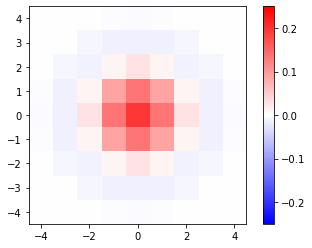

Frequency response:


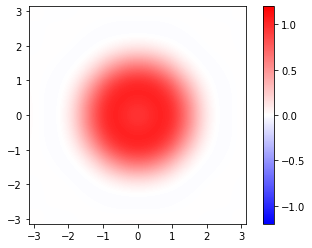

In [6]:
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_kernel_w = 9  # Horizontal size of the kernel, also its vertical size. Must be odd. 9 is a good choice when oversampling == 2.

def circularLowpassKernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size, must be odd.
  with np.errstate(divide='ignore',invalid='ignore'):    
      kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel 

def rotatedCosineWindow(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
  return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

aa_kernel_cutoff_pi = circularLowpassKernel(np.pi/oversampling, aa_kernel_w)*rotatedCosineWindow(aa_kernel_w)

print("Kernel:")
plt.imshow(aa_kernel_cutoff_pi, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-aa_kernel_w/2, aa_kernel_w/2, -aa_kernel_w/2, aa_kernel_w/2])
plt.colorbar()
plt.show()

print("Frequency response:")
freq_resp = np.real(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(aa_kernel_cutoff_pi, 100, mode = 'constant', constant_values = 0), shift = (-aa_kernel_w//2-99, -aa_kernel_w//2-99), axis = (0, 1)))))
plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.colorbar()
plt.show()

aa_kernel_cutoff_pi = tf.repeat(tf.expand_dims(tf.constant(aa_kernel_cutoff_pi, dtype=tf.float32), 2), 3, axis=2)
aa_kernel_cutoff_pi = tf.expand_dims(aa_kernel_cutoff_pi, -1) # (height, width, output channels, input channels)

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They are saved for visual inspection.

In [80]:
photos_dir = "D:/roman/source_grass_images_subset"
save_filtered_photos_dir = "D:/roman/filtered_grass_images_subset" # save folder, or None to disable saving

def load_and_filter_image(filepath):
    image = tf.io.decode_png(tf.io.read_file(filepath), channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) * 2 - 1
    image = tf.nn.depthwise_conv2d([image], aa_kernel_cutoff_pi, [1, 1, 1, 1], "VALID")[0]
    if save_filtered_photos_dir is not None:
        basename = tf.py_function(lambda string_tensor: os.path.basename(string_tensor.numpy()), [filepath], tf.string)
        tf.io.write_file(save_filtered_photos_dir + "/" + basename, tf.io.encode_png(tf.image.convert_image_dtype((image + 1)/2, dtype=tf.dtypes.uint8, saturate=True)))
    return image

train_dataset = tf.data.Dataset.list_files(photos_dir + "/*.png")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)

# Force execution:
for image in train_dataset:
    print(image)

tf.Tensor(
[[[ 0.41344836  0.34044158 -0.31597438]
  [ 0.5977998   0.5353658  -0.13392386]
  [ 0.77200323  0.72515166  0.04142166]
  ...
  [-0.42407134 -0.37597135 -0.9104976 ]
  [-0.21679455 -0.11880232 -0.76733476]
  [ 0.05860353  0.19952616 -0.5706659 ]]

 [[ 0.3571558   0.27437386 -0.3643548 ]
  [ 0.5534664   0.4812234  -0.16817024]
  [ 0.7686626   0.7125561   0.04974203]
  ...
  [-0.45070863 -0.40749973 -0.9215083 ]
  [-0.23750563 -0.13958687 -0.77529025]
  [ 0.0546687   0.20746924 -0.56698865]]

 [[ 0.3878289   0.3032529  -0.3215757 ]
  [ 0.5245913   0.44975474 -0.18372285]
  [ 0.7252231   0.6646441   0.02097758]
  ...
  [-0.45334437 -0.41198623 -0.9215242 ]
  [-0.23168543 -0.13079403 -0.7690359 ]
  [ 0.07100237  0.23166008 -0.5487702 ]]

 ...

 [[ 0.10917611  0.27472493 -0.38994485]
  [-0.07163391  0.10417531 -0.5355215 ]
  [-0.06890263  0.11367292 -0.507158  ]
  ...
  [-0.48684594 -0.44471166 -0.80045855]
  [-0.476748   -0.43517768 -0.79725456]
  [-0.34639874 -0.3036198  -0.677

## TODO a lot of stuff